# Hybrid model for pneumonia detection
## 1. Setup and configuration
### 1.1. Installing libraries


In [3]:
!pip install pennylane scikit-learn numpy scipy matplotlib pandas pennylane-qiskit kagglehub scikit-image seaborn pillow opencv-python torch torchvision pennylane-lightning-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 911.3/911.3 kB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 93.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 103.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 98.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 

### 1.2. Configuration

In [4]:
from dataclasses import dataclass
import torch
import numpy as np
import random
import os

@dataclass
class ExperimentConfig:
    # Experiment Metadata
    project_name: str = "Hybrid_ResNet50_QNN_Pneumonia"
    seed: int = 102312
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

    # Data Paths
    data_root: str = "/"
    output_dir: str = "./results"

    # Classical Backbone
    backbone_name: str = "resnet50"
    feature_dim: int = 2048  # 2048 for ResNet50

    # Quantum Components
    n_qubits: int = 7
    n_layers: int = 4
    encoding_method: str = "amplitude"  # 'amplitude' or 'angle'

    # Training Hyperparams
    batch_size: int =  64
    learning_rate: float = 0.01
    epochs: int = 25
    patience: int = 5

    # Preprocessing
    reduction_method: str = "selectkbest"  # 'pca', 'lda', or 'selectkbest'
    target_dims: int = 96  # Dimensionality after reduction

    # Quantum training mode
    use_ensemble: bool = False      # False → single model, True → ensemble
    ensemble_size: int = 3          # Number of models in ensemble

    # Class weights
    w_normal: float = 1.0
    w_pneumonia: float = 2.0

    # Colab
    use_colab: bool = True
    colab_data_path: str = "/qml-pneumonia/"


def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"🔒 Global seed set to {seed}")


CFG = ExperimentConfig()
seed_everything(CFG.seed)
os.makedirs(CFG.output_dir, exist_ok=True)


🔒 Global seed set to 102312


### 1.3. Dataset

In [5]:
import kagglehub

# Download latest version of the dataset
CFG.data_root = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia") + "/chest_xray/"
print("Path to dataset files:", CFG.data_root)

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumonia/chest_xray/


### 2. Data loading and feature extraction

In [6]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import os

# Deterministic transforms (no augmentation)
def get_transforms(img_size: int = 224):
    """
    Deterministic preprocessing for feature extraction.
    """
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
    return transforms.Compose(
        [
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            normalize,
        ]
    )


def get_dataloaders(config: ExperimentConfig):
    """
    Create DataLoaders for train/val/test using ImageFolder.
    """
    loaders = {}
    splits = ["train", "test", "val"]

    print(f"Loading data from {config.data_root}")

    for split in splits:
        path = os.path.join(config.data_root, split)
        if not os.path.exists(path):
            print(f"Warning: Split '{split}' not found at {path}")
            continue

        dataset = datasets.ImageFolder(
            root=path,
            transform=get_transforms(),
        )

        loaders[split] = DataLoader(
            dataset,
            batch_size=config.batch_size,
            shuffle=False,  # keep False to align features with filenames
            num_workers=2,
            pin_memory=True,
        )

        print(f"{split.upper()} - Found {len(dataset)} images")

    return loaders


class FeatureExtractor(nn.Module):
    """
    Wraps ResNet50 to output raw features instead of classification scores.
    """

    def __init__(self):
        super().__init__()
        # Works on older and newer torchvision
        try:
            # New API (torchvision >= 0.13)
            weights = models.ResNet50Weights.IMAGENET1K_V2
            backbone = models.resnet50(weights=weights)
        except AttributeError:
            # Old API (torchvision < 0.13, e.g. many Colab runtimes)
            backbone = models.resnet50(pretrained=True)

        backbone.fc = nn.Identity()  # 2048-dim features
        backbone.eval()
        self.backbone = backbone

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.backbone(x)


def get_aug_transforms(img_size: int = 224):
    """
    Augmentation used only for offline-augmented training features.
    """
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
    return transforms.Compose(
        [
            transforms.Resize((img_size, img_size)),
            transforms.RandomRotation(15),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.1, contrast=0.1),
            transforms.ToTensor(),
            normalize,
        ]
    )


def run_feature_extraction_augmented(config: ExperimentConfig):
    """
    Extracts ResNet50 features and saves them to disk.

    - For train/val/test: saves CLEAN features.
    - For train only: also saves AUGMENTED features.
    """
    device = torch.device(config.device)
    model = FeatureExtractor().to(device)

    # Deterministic loaders
    clean_loaders = get_dataloaders(config)

    save_dir = os.path.join(config.output_dir, "features")
    os.makedirs(save_dir, exist_ok=True)
    metadata = []

    print("\n🚀 Starting augmented feature extraction...")

    with torch.no_grad():
        for split, loader in clean_loaders.items():
            # 1) CLEAN features for all splits
            for batch_idx, (images, labels) in enumerate(
                tqdm(loader, desc=f"Extracting {split} (Clean)")
            ):
                images = images.to(device)
                with torch.amp.autocast('cuda'):
                    features = model(images)
                features = features.cpu().numpy()

                start_idx = batch_idx * config.batch_size
                for i, feat in enumerate(features):
                    global_idx = start_idx + i
                    original_path, label_idx = loader.dataset.samples[global_idx]
                    filename = os.path.basename(original_path)
                    classname = loader.dataset.classes[label_idx]

                    save_name = f"{split}_CLEAN_{classname}_{filename}.npy"
                    save_path = os.path.join(save_dir, save_name)
                    np.save(save_path, feat)

                    metadata.append(
                        {
                            "feature_path": save_path,
                            "label": label_idx,
                            "classname": classname,
                            "split": split,
                            "original_path": original_path,
                        }
                    )

            # 2) AUGMENTED features for train only
            if split == "train":
                aug_dataset = datasets.ImageFolder(
                    root=os.path.join(config.data_root, split),
                    transform=get_aug_transforms(img_size=224),
                )
                aug_loader = DataLoader(
                    aug_dataset,
                    batch_size=config.batch_size,
                    shuffle=False,
                    num_workers=2,
                    pin_memory=True,
                )

                for batch_idx, (images, labels) in enumerate(
                    tqdm(aug_loader, desc=f"Extracting {split} (Augmented)")
                ):
                    images = images.to(device)
                    with torch.amp.autocast('cuda'):
                        features = model(images)
                    features = features.cpu().numpy()

                    start_idx = batch_idx * config.batch_size
                    for i, feat in enumerate(features):
                        global_idx = start_idx + i
                        original_path, label_idx = aug_loader.dataset.samples[global_idx]
                        filename = os.path.basename(original_path)
                        classname = aug_loader.dataset.classes[label_idx]

                        save_name = f"{split}_AUG_{classname}_{filename}.npy"
                        save_path = os.path.join(save_dir, save_name)
                        np.save(save_path, feat)

                        metadata.append(
                            {
                                "feature_path": save_path,
                                "label": label_idx,
                                "classname": classname,
                                "split": split,
                                "original_path": original_path,
                            }
                        )

    meta_path = os.path.join(config.output_dir, "metadata.csv")
    pd.DataFrame(metadata).to_csv(meta_path, index=False)
    print(f"✅ Augmented extraction complete. Metadata saved to {meta_path}")
    return meta_path


# Run extraction
meta_csv_path = run_feature_extraction_augmented(CFG)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 108MB/s]


Loading data from /kaggle/input/chest-xray-pneumonia/chest_xray/
TRAIN - Found 5216 images
TEST - Found 624 images
VAL - Found 16 images

🚀 Starting augmented feature extraction...


Extracting train (Clean):   0%|          | 0/21 [00:00<?, ?it/s]

Extracting train (Augmented):   0%|          | 0/21 [00:00<?, ?it/s]

Extracting test (Clean):   0%|          | 0/3 [00:00<?, ?it/s]

Extracting val (Clean):   0%|          | 0/1 [00:00<?, ?it/s]

✅ Augmented extraction complete. Metadata saved to ./results/metadata.csv


### 3. Classical preprocessing


In [7]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
import joblib
import os


def load_features(config: ExperimentConfig):
    """
    Load saved .npy feature files according to metadata.csv.
    """
    meta_path = os.path.join(config.output_dir, "metadata.csv")
    if not os.path.exists(meta_path):
        raise FileNotFoundError(
            f"Metadata CSV not found at {meta_path}. Run feature extraction first."
        )

    df = pd.read_csv(meta_path)
    splits = ["train", "val", "test"]

    X, y = {}, {}

    print("📂 Loading raw features...")
    for split in splits:
        subset = df[df["split"] == split]
        if subset.empty:
            print(f"Warning: no rows for split='{split}' in metadata.")
            continue

        features = [np.load(path) for path in subset["feature_path"]]
        X[split] = np.vstack(features)
        y[split] = subset["label"].values

        print(f"{split.upper()}: X shape = {X[split].shape}, y shape = {y[split].shape}")

    return X, y


def fix_validation_split(X, y, config: ExperimentConfig):
    """
    Merge original train and val, then create a new 80/20 split.
    """
    print("\n⚠️ Fixing small validation set issue...")

    X_combined = np.concatenate([X["train"], X["val"]])
    y_combined = np.concatenate([y["train"], y["val"]])

    X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(
        X_combined,
        y_combined,
        test_size=0.2,
        stratify=y_combined,
        random_state=config.seed,
    )

    X["train"], y["train"] = X_train_new, y_train_new
    X["val"], y["val"] = X_val_new, y_val_new

    print(f" Original Val size: {len(y['val'])}")
    print(f" New Train size: {len(y['train'])}")
    return X, y


def build_pipeline(config: ExperimentConfig):
    """
    Build sklearn preprocessing pipeline: scaling + dimensionality reduction + encoding scaling.
    """
    steps = [("scaler", StandardScaler())]

    if config.reduction_method == "pca":
        steps.append(
            ("reducer", PCA(n_components=config.target_dims, random_state=config.seed))
        )
    elif config.reduction_method == "lda":
        steps.append(("reducer", LDA(n_components=min(config.target_dims, 1))))
    elif config.reduction_method == "selectkbest":
        steps.append(
            ("selector", SelectKBest(score_func=f_classif, k=config.target_dims))
        )

    if config.encoding_method == "amplitude":
        steps.append(("normalizer", Normalizer(norm="l2")))
    elif config.encoding_method == "angle":
        steps.append(("minmax", MinMaxScaler(feature_range=(0, np.pi))))

    return Pipeline(steps)


def run_classical_preprocessing(config: ExperimentConfig):
    # 1. Load data
    X, y = load_features(config)

    # 2. Fix validation split
    X, y = fix_validation_split(X, y, config)

    # 3. Build & fit pipeline
    pipeline = build_pipeline(config)
    print(f"\n🔄 Fitting {config.reduction_method.upper()} pipeline...")
    pipeline.fit(X["train"], y["train"])

    # 4. Transform and save
    X_processed = {
        "train": pipeline.transform(X["train"]),
        "val": pipeline.transform(X["val"]),
        "test": pipeline.transform(X["test"]),
    }

    processed_dir = os.path.join(config.output_dir, "processed_data")
    os.makedirs(processed_dir, exist_ok=True)

    for split in ["train", "val", "test"]:
        np.save(os.path.join(processed_dir, f"X_{split}.npy"), X_processed[split])
        np.save(os.path.join(processed_dir, f"y_{split}.npy"), y[split])

    pipeline_path = os.path.join(config.output_dir, "preprocessing_pipeline.joblib")
    joblib.dump(pipeline, pipeline_path)

    print("✅ Preprocessing complete. Data ready for quantum training.")
    return X_processed, y


# Run preprocessing
X_data, y_data = run_classical_preprocessing(CFG)


📂 Loading raw features...
TRAIN: X shape = (10432, 2048), y shape = (10432,)
VAL: X shape = (16, 2048), y shape = (16,)
TEST: X shape = (624, 2048), y shape = (624,)

⚠️ Fixing small validation set issue...
 Original Val size: 2090
 New Train size: 8358

🔄 Fitting SELECTKBEST pipeline...
✅ Preprocessing complete. Data ready for quantum training.


### 4. Quantum model and training

In [8]:
import pennylane as qml
from pennylane import numpy as pnp
import numpy as np
from tqdm.notebook import tqdm
import os
import json
import time
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import math

# ⭐ NEW: Cosine Annealing Scheduler
class CosineAnnealingScheduler:
    """Smooth cosine annealing schedule instead of manual steps."""
    def __init__(self, initial_lr=0.002, min_lr=0.0001, epochs=50, warmup_epochs=2):
        self.initial_lr = initial_lr
        self.min_lr = min_lr
        self.epochs = epochs
        self.warmup_epochs = warmup_epochs

    def get_lr(self, epoch):
        """Compute learning rate for given epoch."""
        if epoch < self.warmup_epochs:
            return self.initial_lr * (epoch + 1) / self.warmup_epochs
        progress = (epoch - self.warmup_epochs) / (self.epochs - self.warmup_epochs)
        return self.min_lr + (self.initial_lr - self.min_lr) * (1 + math.cos(math.pi * progress)) / 2

    def step(self, optimizer, epoch):
        """Update optimizer's learning rate."""
        lr = self.get_lr(epoch)
        optimizer.stepsize = lr
        return lr

def get_device(config):
    """Create a PennyLane device with GPU acceleration if available."""
    try:
        return qml.device(
            'lightning.gpu',
            wires=config.n_qubits,
            shots=None
        )
    except Exception:
        return qml.device("default.qubit", wires=config.n_qubits, shots=None)

def embedding_layer(features, config):
    """Encode classical features into a quantum state."""
    wires = range(config.n_qubits)

    if config.encoding_method == "amplitude":
        qml.AmplitudeEmbedding(
            features=features, wires=wires, normalize=True, pad_with=0.0
        )
    elif config.encoding_method == "angle":
        for i in range(len(features)):
            qml.RY(features[i], wires[i % config.n_qubits])

def train_quantum_model(config, X_data, y_data, use_ensemble=False, ensemble_size=3):
    """
    Complete optimized training function with cosine annealing scheduler.
    """
    print(f"\n{'='*60}")
    print(f"Training {'Ensemble' if use_ensemble else 'single'} quantum model")
    print(f"{'='*60}")

    # Initialize device and quantum node
    print(f"⚛️ Initializing Quantum Model ({config.n_qubits} qubits, {config.n_layers} layers)...")
    dev = get_device(config)

    @qml.qnode(dev, interface="autograd", diff_method="adjoint", cache=True)
    def qnode(inputs, params):
        embedding_layer(inputs, config)
        qml.StronglyEntanglingLayers(params, wires=range(config.n_qubits))
        return qml.expval(qml.PauliZ(0))

    # Initialize parameters
    param_shape = qml.StronglyEntanglingLayers.shape(
        n_layers=config.n_layers, n_wires=config.n_qubits
    )
    params = pnp.random.uniform(0, 2 * pnp.pi, size=param_shape, requires_grad=True)

    # ⭐ OPTIMIZED: Cosine annealing optimizer (replaces manual schedule)
    opt = qml.AdamOptimizer(stepsize=config.learning_rate)
    scheduler = CosineAnnealingScheduler(
        initial_lr=config.learning_rate,
        min_lr=0.0001,
        epochs=config.epochs,
        warmup_epochs=2
    )

    def cost_fn(params, x_batch, y_batch):
        preds = qnode(x_batch, params)
        targets = pnp.array([1 if y == 1 else -1 for y in y_batch], requires_grad=False)
        w_normal = config.w_normal
        w_pneumonia = config.w_pneumonia
        batch_weights = pnp.array(
            [w_normal if t == -1 else w_pneumonia for t in targets],
            requires_grad=False,
        )
        return pnp.mean(batch_weights * ((preds - targets) ** 2))

    # Training setup
    history = {"train_loss": [], "val_loss": [], "val_acc": []}
    best_val_loss = float("inf")
    best_params = None
    patience_counter = 0

    X_train, y_train = X_data["train"], y_data["train"]
    X_val, y_val = X_data["val"], y_data["val"]

    batch_size = config.batch_size
    n_batches = len(X_train) // batch_size

    print(f"🚀 Starting training for {config.epochs} epochs...")
    print(f"Batch size: {batch_size}, Batches per epoch: {n_batches}")
    start_time = time.time()

    for epoch in range(config.epochs):
        # ⭐ NEW: Smooth LR scheduling (no more manual steps at 15/35)
        # Add periodic saves every 5 epochs
        if epoch % 5 == 0:
            np.save("./results/checkpoint_epoch_{}.npy".format(epoch), params)

        lr = scheduler.step(opt, epoch)

        # Shuffle data
        perm = np.random.permutation(len(X_train))
        X_train_shuffled = X_train[perm]
        y_train_shuffled = y_train[perm]

        epoch_loss = 0.0

        # Training batches
        with tqdm(total=n_batches, desc=f"Epoch {epoch+1}/{config.epochs}", leave=False) as pbar:
            for i in range(n_batches):
                batch_idx = slice(i * batch_size, (i + 1) * batch_size)
                X_batch = X_train_shuffled[batch_idx]
                y_batch = y_train_shuffled[batch_idx]

                params, loss = opt.step_and_cost(
                    lambda p: cost_fn(p, X_batch, y_batch), params
                )
                epoch_loss += loss
                pbar.update(1)
                pbar.set_postfix({"loss": f"{loss:.4f}", "lr": f"{lr:.6f}"})

        # Validation
        avg_train_loss = epoch_loss / n_batches
        val_loss = cost_fn(params, X_val, y_val)
        val_preds_raw = qnode(X_val, params)
        val_preds = (val_preds_raw > 0).astype(int)
        val_acc = accuracy_score(y_val, val_preds)

        # Record history
        history["train_loss"].append(float(avg_train_loss))
        history["val_loss"].append(float(val_loss))
        history["val_acc"].append(float(val_acc))

        # Logging with LR
        print(
            f" Epoch {epoch+1}: Train Loss {avg_train_loss:.4f} | "
            f"Val Loss {val_loss:.4f} | Val Acc {val_acc:.4f} | LR {lr:.6f}"
        )

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = float(val_loss)
            best_params = params.copy()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= config.patience:
            print(f"⏹️  Early stopping at epoch {epoch+1}")
            break

    train_time = time.time() - start_time
    print(f"✅ Training complete in {train_time:.1f}s ({train_time/len(history['train_loss']):.1f}s/epoch)")
    print(f"   Best Val Loss: {best_val_loss:.4f}")

    # Save history
    history_path = os.path.join(config.output_dir, "training_history.json")
    with open(history_path, 'w') as f:
        json.dump(history, f)

    if use_ensemble:
        print("🔄 Ensemble training not implemented in this version")
        return best_params, qnode, history

    return best_params, qnode, history

best_params, qnode, history = train_quantum_model(CFG, X_data, y_data)

/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(



Training single quantum model
⚛️ Initializing Quantum Model (7 qubits, 4 layers)...
🚀 Starting training for 25 epochs...
Batch size: 256, Batches per epoch: 32


Epoch 1/25:   0%|          | 0/32 [00:00<?, ?it/s]

 Epoch 1: Train Loss 2.3634 | Val Loss 2.3286 | Val Acc 0.5971 | LR 0.001000


Epoch 2/25:   0%|          | 0/32 [00:00<?, ?it/s]

 Epoch 2: Train Loss 2.2735 | Val Loss 2.2226 | Val Acc 0.6306 | LR 0.002000


Epoch 3/25:   0%|          | 0/32 [00:00<?, ?it/s]

 Epoch 3: Train Loss 2.1836 | Val Loss 2.1398 | Val Acc 0.6517 | LR 0.002000


Epoch 4/25:   0%|          | 0/32 [00:00<?, ?it/s]

 Epoch 4: Train Loss 2.1067 | Val Loss 2.0635 | Val Acc 0.6660 | LR 0.001991


Epoch 5/25:   0%|          | 0/32 [00:00<?, ?it/s]

 Epoch 5: Train Loss 2.0350 | Val Loss 1.9968 | Val Acc 0.6708 | LR 0.001965


Epoch 6/25:   0%|          | 0/32 [00:00<?, ?it/s]

 Epoch 6: Train Loss 1.9745 | Val Loss 1.9356 | Val Acc 0.6837 | LR 0.001921


Epoch 7/25:   0%|          | 0/32 [00:00<?, ?it/s]

 Epoch 7: Train Loss 1.9157 | Val Loss 1.8828 | Val Acc 0.6900 | LR 0.001862


Epoch 8/25:   0%|          | 0/32 [00:00<?, ?it/s]

 Epoch 8: Train Loss 1.8704 | Val Loss 1.8384 | Val Acc 0.6976 | LR 0.001787


Epoch 9/25:   0%|          | 0/32 [00:00<?, ?it/s]

 Epoch 9: Train Loss 1.8316 | Val Loss 1.8030 | Val Acc 0.7048 | LR 0.001698


Epoch 10/25:   0%|          | 0/32 [00:00<?, ?it/s]

 Epoch 10: Train Loss 1.7978 | Val Loss 1.7714 | Val Acc 0.7091 | LR 0.001598


Epoch 11/25:   0%|          | 0/32 [00:00<?, ?it/s]

 Epoch 11: Train Loss 1.7676 | Val Loss 1.7437 | Val Acc 0.7072 | LR 0.001487


Epoch 12/25:   0%|          | 0/32 [00:00<?, ?it/s]

 Epoch 12: Train Loss 1.7382 | Val Loss 1.7200 | Val Acc 0.7129 | LR 0.001368


Epoch 13/25:   0%|          | 0/32 [00:00<?, ?it/s]

 Epoch 13: Train Loss 1.7164 | Val Loss 1.6995 | Val Acc 0.7187 | LR 0.001243


Epoch 14/25:   0%|          | 0/32 [00:00<?, ?it/s]

 Epoch 14: Train Loss 1.6961 | Val Loss 1.6817 | Val Acc 0.7206 | LR 0.001115


Epoch 15/25:   0%|          | 0/32 [00:00<?, ?it/s]

 Epoch 15: Train Loss 1.6782 | Val Loss 1.6655 | Val Acc 0.7211 | LR 0.000985


Epoch 16/25:   0%|          | 0/32 [00:00<?, ?it/s]

 Epoch 16: Train Loss 1.6626 | Val Loss 1.6506 | Val Acc 0.7249 | LR 0.000857


Epoch 17/25:   0%|          | 0/32 [00:00<?, ?it/s]

 Epoch 17: Train Loss 1.6457 | Val Loss 1.6365 | Val Acc 0.7282 | LR 0.000732


Epoch 18/25:   0%|          | 0/32 [00:00<?, ?it/s]

 Epoch 18: Train Loss 1.6328 | Val Loss 1.6235 | Val Acc 0.7316 | LR 0.000613


Epoch 19/25:   0%|          | 0/32 [00:00<?, ?it/s]

 Epoch 19: Train Loss 1.6185 | Val Loss 1.6117 | Val Acc 0.7325 | LR 0.000502


Epoch 20/25:   0%|          | 0/32 [00:00<?, ?it/s]

 Epoch 20: Train Loss 1.6078 | Val Loss 1.6014 | Val Acc 0.7335 | LR 0.000402


Epoch 21/25:   0%|          | 0/32 [00:00<?, ?it/s]

 Epoch 21: Train Loss 1.5988 | Val Loss 1.5930 | Val Acc 0.7340 | LR 0.000313


Epoch 22/25:   0%|          | 0/32 [00:00<?, ?it/s]

 Epoch 22: Train Loss 1.5883 | Val Loss 1.5864 | Val Acc 0.7344 | LR 0.000238


Epoch 23/25:   0%|          | 0/32 [00:00<?, ?it/s]

 Epoch 23: Train Loss 1.5853 | Val Loss 1.5812 | Val Acc 0.7359 | LR 0.000179


Epoch 24/25:   0%|          | 0/32 [00:00<?, ?it/s]

 Epoch 24: Train Loss 1.5806 | Val Loss 1.5772 | Val Acc 0.7359 | LR 0.000135


Epoch 25/25:   0%|          | 0/32 [00:00<?, ?it/s]

 Epoch 25: Train Loss 1.5763 | Val Loss 1.5740 | Val Acc 0.7364 | LR 0.000109
✅ Training complete in 7483.7s (299.3s/epoch)
   Best Val Loss: 1.5740


### 5. Post processing: Threshold scan

In [10]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

def binary_search_threshold(y_true, probs, metric="balanced_acc", tol=1e-6, max_iter=50):
    """
    Binary search for optimal threshold using any metric.

    Args:
        y_true: ground truth labels
        probs: predicted probabilities [0,1]
        metric: 'balanced_acc', 'accuracy', 'f1_macro', etc.
        tol: convergence tolerance
        max_iter: max iterations

    Returns:
        best_threshold, best_metric_value
    """
    low, high = 0.1, 0.95
    best_threshold = 0.5
    best_metric = 0.0

    for i in range(max_iter):
        mid = (low + high) / 2
        preds_mid = (probs > mid).astype(int)

        # Compute metric
        tn, fp, fn, tp = confusion_matrix(y_true, preds_mid).ravel()
        sens = tp / (tp + fn + 1e-10)
        spec = tn / (tn + fp + 1e-10)

        if metric == "balanced_acc":
            current_metric = (sens + spec) / 2
        elif metric == "accuracy":
            current_metric = accuracy_score(y_true, preds_mid)
        elif metric == "f1_macro":
            current_metric = f1_score(y_true, preds_mid, average="macro")

        # Update best
        if current_metric > best_metric:
            best_metric = current_metric
            best_threshold = mid

        # Binary search logic
        if current_metric > best_metric:  # Still improving, search finer
            high = mid
        else:
            low = mid

        if high - low < tol:
            break

    return best_threshold, best_metric


# --- FIX: Calculate test_probs and test_preds ---
print("Evaluating model on test set...")
# Get raw predictions from the trained qnode
raw_test_preds = np.array([qnode(x, best_params) for x in X_data["test"]])

# Convert expectation values [-1, 1] to probabilities [0, 1]
# Assuming +1 is class 1 (Pneumonia) and -1 is class 0 (Normal)
test_probs = (raw_test_preds + 1) / 2

y_test = y_data["test"]
probs = test_probs

print("🔍 Binary search for optimal threshold...")
best_thresh, best_bal_acc = binary_search_threshold(y_test, probs, metric="balanced_acc")

print(f"\n{'='*50}")
print(f"🏆 Optimal Threshold: {best_thresh:.6f}")
print(f"   Balanced Accuracy: {best_bal_acc:.4f}")
print(f"{'='*50}")

# Verify with exact computation
test_preds = (probs > best_thresh).astype(int) # Define test_preds here
tn, fp, fn, tp = confusion_matrix(y_test, test_preds).ravel()
sens = tp / (tp + fn + 1e-10) # Added epsilon for stability
spec = tn / (tn + fp + 1e-10) # Added epsilon for stability
acc = accuracy_score(y_test, test_preds)

print(f"Verification:")
print(f"  Accuracy: {acc:.4f}")
print(f"  Sensitivity: {sens:.4f}")
print(f"  Specificity: {spec:.4f}")
print(f"  Balanced Acc: {(sens+spec)/2:.4f}")


Evaluating model on test set...
🔍 Binary search for optimal threshold...

🏆 Optimal Threshold: 0.525000
   Balanced Accuracy: 0.5491
Verification:
  Accuracy: 0.6522
  Sensitivity: 0.9615
  Specificity: 0.1368
  Balanced Acc: 0.5491


### 6. Evaluation plots and SOČ metrics

=== Visualization for SOČ ===
📈 Training history saved to: ./results/training_history.png


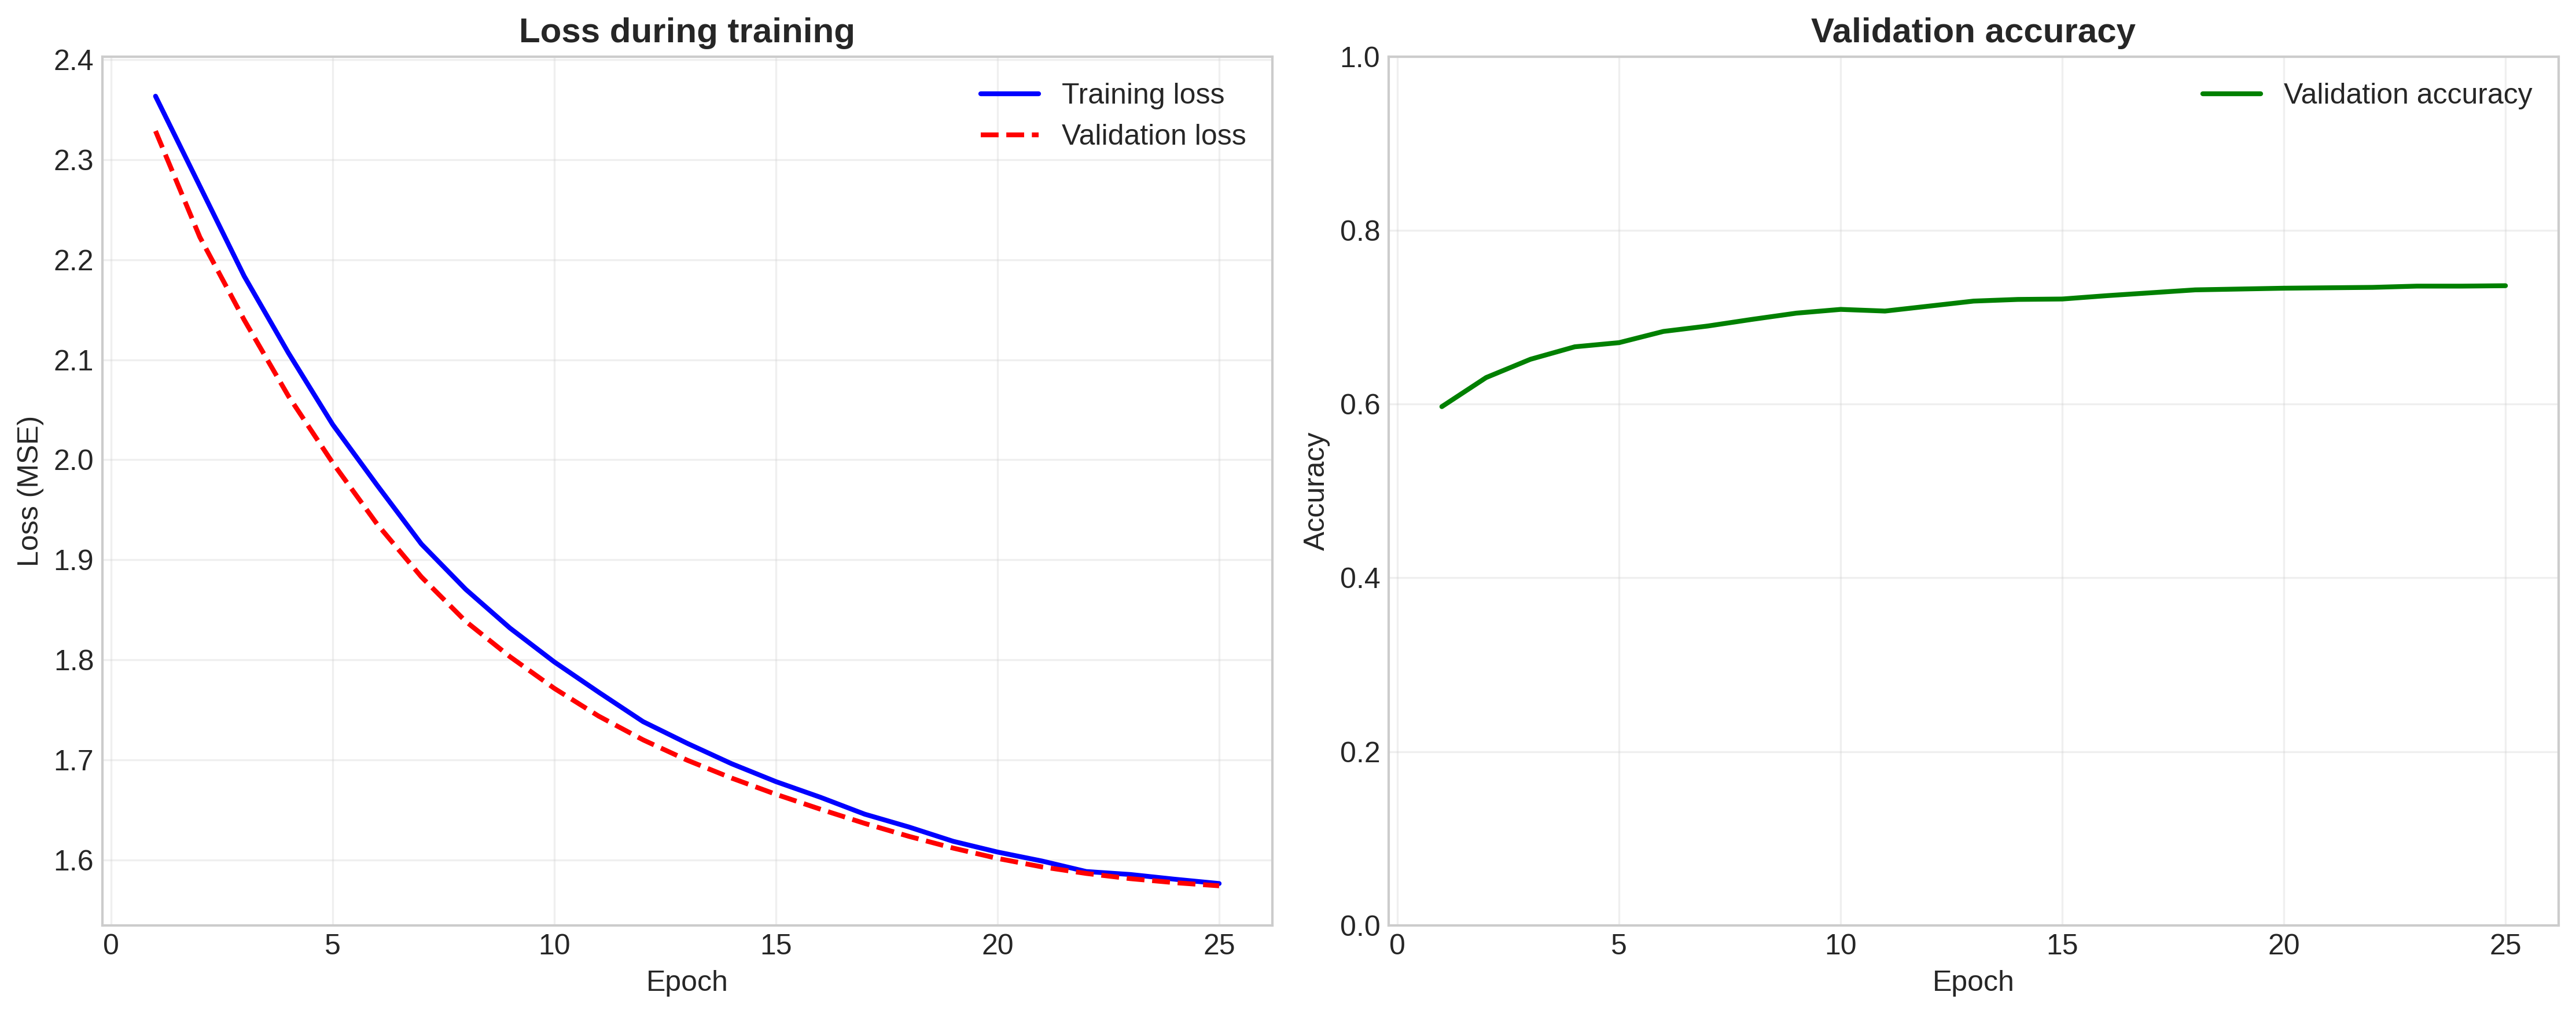

📊 Evaluation plots saved to: ./results/evaluation_metrics.png


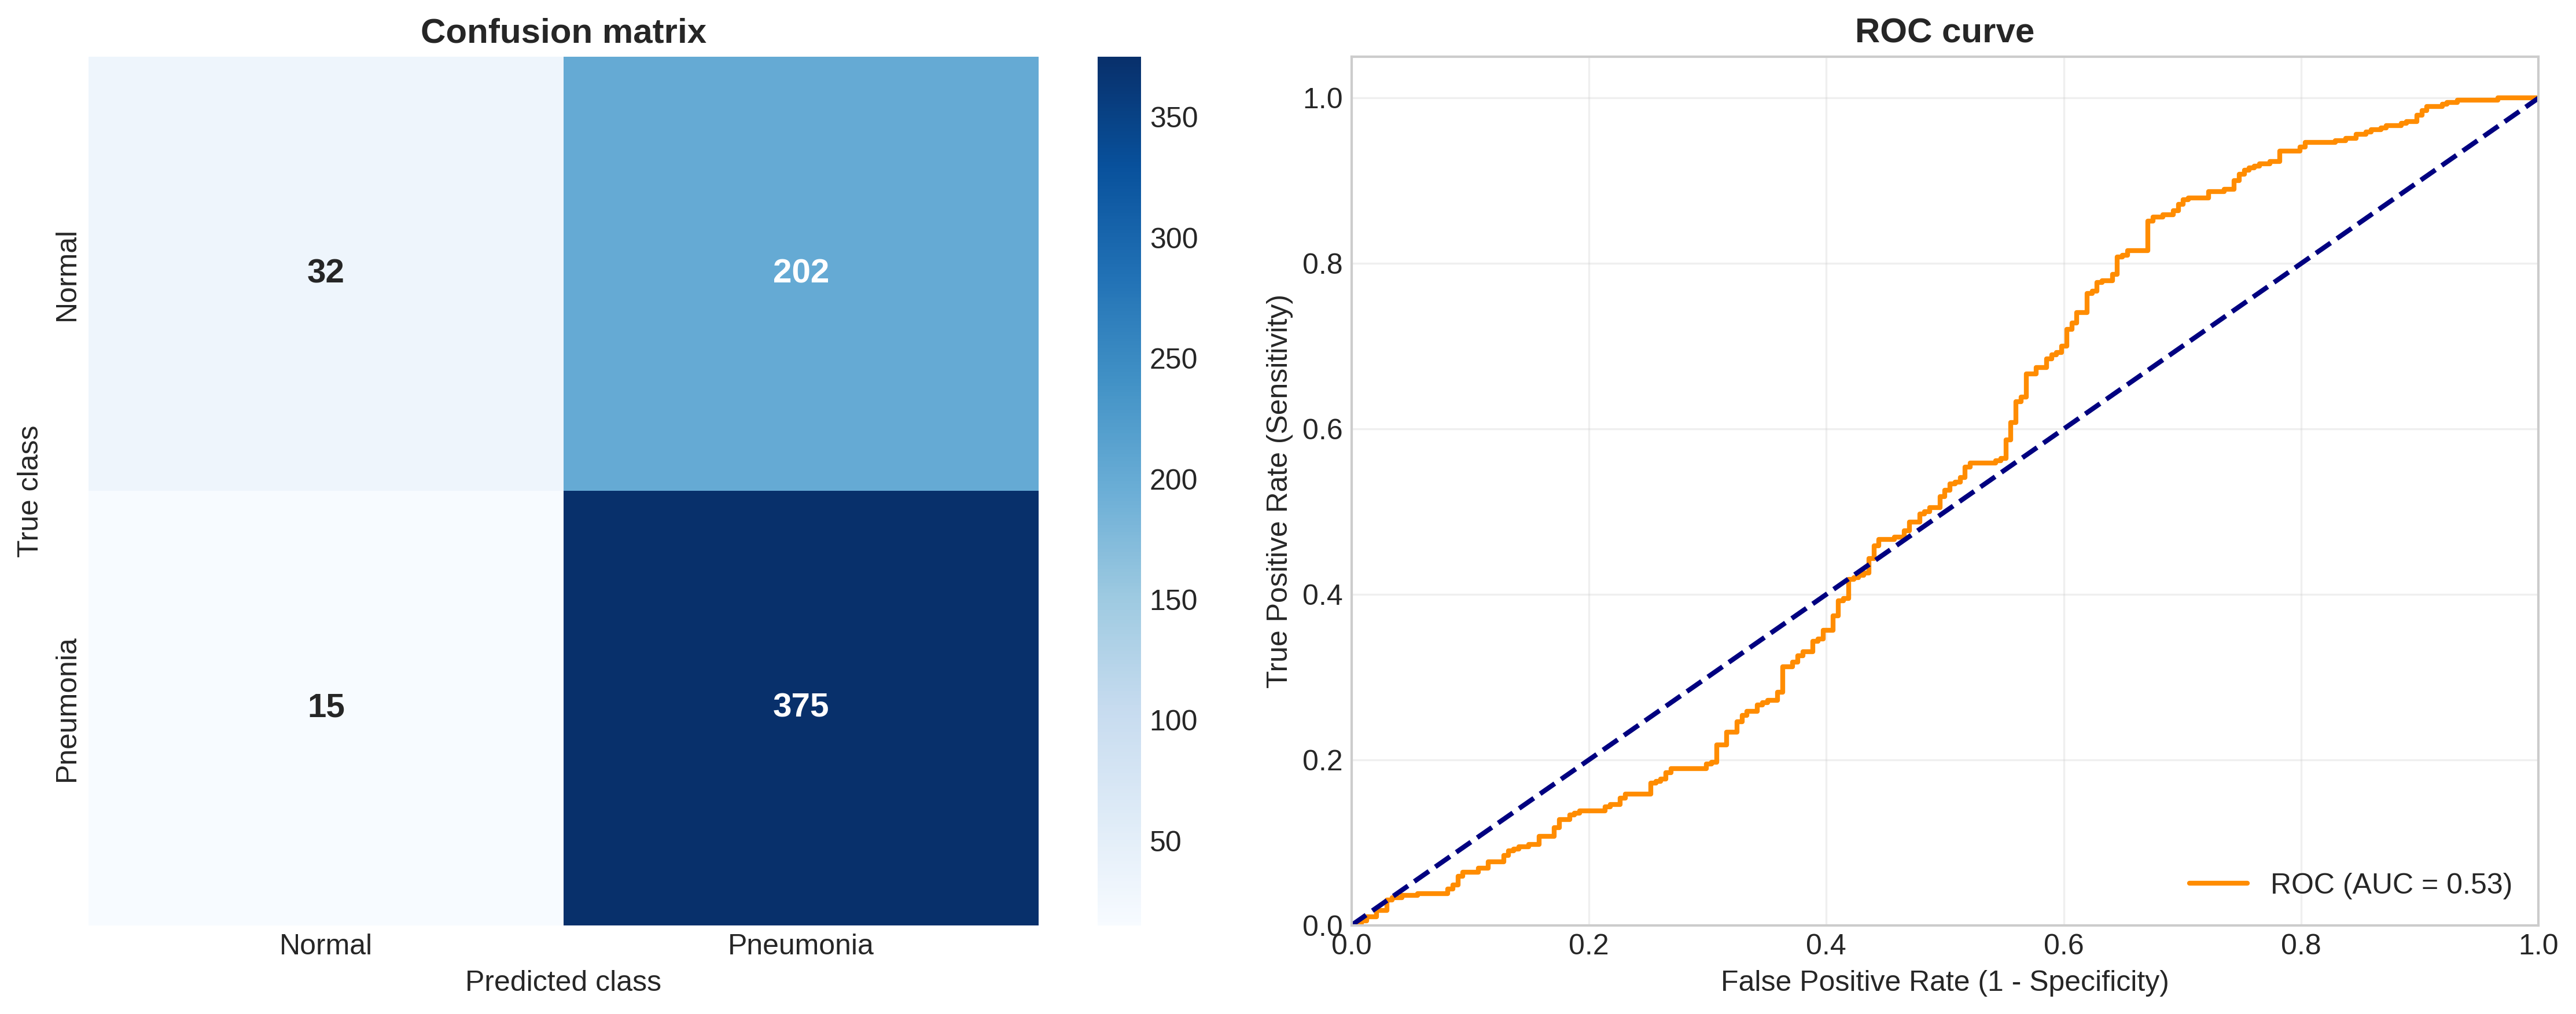


📝 Numbers for SOČ table:
-----------------------------------
Number of test images: 624
TP (Correct Pneumonia): 375
TN (Correct Normal): 32
FP (False alarm): 202
FN (Missed disease): 15
-----------------------------------
Sensitivity (Recall): 0.9615
Specificity: 0.1368
AUC: 0.5288


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
import numpy as np
import os

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({"font.size": 12, "figure.dpi": 300})


def plot_training_history(history, save_dir: str):
    epochs = range(1, len(history["train_loss"]) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    ax1.plot(epochs, history["train_loss"], "b-", label="Training loss", linewidth=2)
    ax1.plot(epochs, history["val_loss"], "r--", label="Validation loss", linewidth=2)
    ax1.set_title("Loss during training", fontweight="bold")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss (MSE)")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.plot(epochs, history["val_acc"], "g-", label="Validation accuracy", linewidth=2)
    ax2.set_title("Validation accuracy", fontweight="bold")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.set_ylim(0, 1.0)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    save_path = os.path.join(save_dir, "training_history.png")
    plt.savefig(save_path, bbox_inches="tight")
    print(f"📈 Training history saved to: {save_path}")
    plt.show()


def plot_evaluation_metrics(y_true, y_pred, y_probs, save_dir: str):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        ax=ax1,
        xticklabels=["Normal", "Pneumonia"],
        yticklabels=["Normal", "Pneumonia"],
        annot_kws={"size": 14, "weight": "bold"},
    )
    ax1.set_title("Confusion matrix", fontweight="bold")
    ax1.set_ylabel("True class")
    ax1.set_xlabel("Predicted class")

    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    ax2.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC (AUC = {roc_auc:.2f})")
    ax2.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel("False Positive Rate (1 - Specificity)")
    ax2.set_ylabel("True Positive Rate (Sensitivity)")
    ax2.set_title("ROC curve", fontweight="bold")
    ax2.legend(loc="lower right")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    save_path = os.path.join(save_dir, "evaluation_metrics.png")
    plt.savefig(save_path, bbox_inches="tight")
    print(f"📊 Evaluation plots saved to: {save_path}")
    plt.show()


print("=== Visualization for SOČ ===")
plot_training_history(history, CFG.output_dir)
plot_evaluation_metrics(y_data["test"], test_preds, test_probs, CFG.output_dir)

cm = confusion_matrix(y_data["test"], test_preds)
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("\n📝 Numbers for SOČ table:")
print("-----------------------------------")
print(f"Number of test images: {len(y_data['test'])}")
print(f"TP (Correct Pneumonia): {tp}")
print(f"TN (Correct Normal): {tn}")
print(f"FP (False alarm): {fp}")
print(f"FN (Missed disease): {fn}")
print("-----------------------------------")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"AUC: {roc_auc_score(y_data['test'], test_probs):.4f}")
